# Using `xbatcher` to train an autoencoder

---

## Overview

In previous notebooks we have demonstrated how `xbatcher` converts both toy `xarray` objects into tensors and back again. In this notebook we incorporate these functions in an end-to-end workflow training an autoencoder on an elevation dataset. Once trained, the model is used to reconstruct two datasets:

 - The overall elevation tile
 - A data cube of the autoencoder's latent dimension

## Prerequisites

This notebook assumes familiarity with `xarray`, `xbatcher`, and `torch`. You don't have to know how autoencoders work - we explain that when necessary.

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Xarray](https://tutorial.xarray.dev/overview/xarray-in-45-min.html) | Necessary | Array indexing |
| [Xbatcher fundamentals](https://projectpythia.org/xbatcher-deep-learning/notebooks/xbatcher-dataloading/) | Necessary | Passing data to models |
| [PyTorch fundamentals](https://docs.pytorch.org/tutorials/beginner/basics/intro.html) | Helpful | Model training loop |
| [Autoencoders](https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/08-deep-autoencoders.html) | Helpful | More information on how autoencoders work.

- **Time to learn**: 30 minutes.
- **System requirements**:
    - Windows users may hit an import error on `rioxarray` ([link](https://gis.stackexchange.com/questions/417733/unable-to-import-python-rasterio-package-even-though-it-is-installed)). If that happens, add `import osgeo` above `import rioxarray` and that seems to fix the issue.



## Imports

In [21]:
import os
if os.name == 'nt':
    import osgeo

from importlib import reload

# DL stuff
import matplotlib.pyplot as plt
import torch

torch.set_default_dtype(torch.float64)

# Geospatial stuff
import xarray as xr
import xbatcher
import rioxarray
from xbatcher.loaders.torch import MapDataset

# Etc
import numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt

# Locals
import functions
import autoencoder

## Get data

We will start by pulling a segment of NASADEM for Washington's Olympic peninsula. The entire DEM is also available on NASA Earthdata and Planetary Computer.

In [22]:
# Rasterio adds a blank edge. Trim these out.
dem = rioxarray.open_rasterio("../ASTGTMV003_N47W124_dem.tif")
dem = dem.isel(y=slice(0, -1), x=slice(0, -1))
dem = (dem - dem.min()) / (dem.max() - dem.min())
dem

<xarray.DataArray (band: 1, y: 3600, x: 3600)> Size: 104MB
array([[[0.23102867, 0.23608769, 0.23988196, ..., 0.10581788,
         0.10961214, 0.11298482],
        [0.23229342, 0.2386172 , 0.24283305, ..., 0.11045531,
         0.11340641, 0.1163575 ],
        [0.23102867, 0.23819562, 0.24325464, ..., 0.11467116,
         0.1163575 , 0.11804384],
        ...,
        [0.00252951, 0.00252951, 0.00252951, ..., 0.03752108,
         0.03625632, 0.03752108],
        [0.00252951, 0.00252951, 0.00252951, ..., 0.03625632,
         0.03499157, 0.03878583],
        [0.0029511 , 0.0029511 , 0.0029511 , ..., 0.03667791,
         0.03625632, 0.04005059]]], shape=(1, 3600, 3600))
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 29kB -124.0 -124.0 -124.0 ... -123.0 -123.0 -123.0
  * y            (y) float64 29kB 48.0 48.0 48.0 48.0 ... 47.0 47.0 47.0 47.0
    spatial_ref  int64 8B 0

Note that we rescaled the DEM to be in the range [0, 1]. This modification makes it easier for the autoencoder to train.

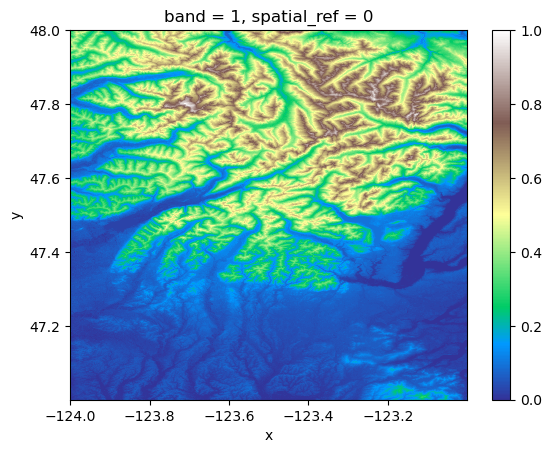

In [23]:
dem.isel(band=0).plot.imshow(cmap="terrain")

## Generate training examples
Here, we use xbatcher to generate patches of terrain. Even though we did not specify the `band` axis in the `BatchGenerator`, this axis still propagates to the output tensor's second axis. Remember that torch data loaders add a batch dimension, so the tensor's first axis is not relevant to the original xarray object. 

In [24]:
bgen_x = xbatcher.BatchGenerator(
    dem,
    input_dims=dict(x=32, y=32),
    input_overlap=dict(x=16, y=16)
)

ds = MapDataset(
    X_generator=bgen_x
)

loader = torch.utils.data.DataLoader(ds, batch_size=16, shuffle=True)

In [25]:
X = next(iter(loader))

print("Input tensor shape:", X.shape)

Input tensor shape: torch.Size([16, 1, 32, 32])


## Model setup

Here we instantiate the autoencoder class and verify that the output shape is what we expect. Autoencoders compress input data to a latent space and then reconstruct the input from the compressed representation. Usually, we are interested in the compressed result, but during training we are trying to recreate the input exactly. Therefore, the output tensor should match the shape of the input tensor.

Input tensor:

<svg width="177" height="167" style="stroke:rgb(0,0,0);stroke-width:1"> <!-- Horizontal lines -->
    <line x1="10" y1="0" x2="27" y2="17" style="stroke-width:2" />
    <line x1="10" y1="100" x2="27" y2="117" style="stroke-width:2" /> <!-- Vertical lines -->
    <line x1="10" y1="0" x2="10" y2="100" style="stroke-width:2" />
    <line x1="27" y1="17" x2="27" y2="117" style="stroke-width:2" /> <!-- Colored Rectangle -->
    <polygon points="10.0,0.0 27.578209484906253,17.578209484906253 27.578209484906253,117.57820948490625 10.0,100.0"
        style="fill:#ECB172A0;stroke-width:0" /> <!-- Horizontal lines -->
    <line x1="10" y1="0" x2="110" y2="0" style="stroke-width:2" />
    <line x1="27" y1="17" x2="127" y2="17" style="stroke-width:2" /> <!-- Vertical lines -->
    <line x1="10" y1="0" x2="27" y2="17" style="stroke-width:2" />
    <line x1="110" y1="0" x2="127" y2="17" style="stroke-width:2" /> <!-- Colored Rectangle -->
    <polygon points="10.0,0.0 110.0,0.0 127.57820948490625,17.578209484906253 27.578209484906253,17.578209484906253"
        style="fill:#ECB172A0;stroke-width:0" /> <!-- Horizontal lines -->
    <line x1="27" y1="17" x2="127" y2="17" style="stroke-width:2" />
    <line x1="27" y1="117" x2="127" y2="117" style="stroke-width:2" /> <!-- Vertical lines -->
    <line x1="27" y1="17" x2="27" y2="117" style="stroke-width:2" />
    <line x1="127" y1="17" x2="127" y2="117" style="stroke-width:2" /> <!-- Colored Rectangle -->
    <polygon
        points="27.578209484906253,17.578209484906253 127.57820948490625,17.578209484906253 127.57820948490625,117.57820948490625 27.578209484906253,117.57820948490625"
        style="fill:#ECB172A0;stroke-width:0" /> <!-- Text --> <text x="77.578209" y="137.578209" font-size="1.0rem"
        font-weight="100" text-anchor="middle">x: 32</text> <text x="147.578209" y="67.578209" font-size="1.0rem"
        font-weight="100" text-anchor="middle" transform="rotate(0,147.578209,67.578209)">y: 32</text> <text x="8.789105"
        y="128.789105" font-size="1.0rem" font-weight="100" text-anchor="middle"
        transform="rotate(45,8.789105,128.789105)">band: 1</text>
</svg>

Output tensor:

<svg width="177" height="167" style="stroke:rgb(0,0,0);stroke-width:1"> <!-- Horizontal lines -->
    <line x1="10" y1="0" x2="27" y2="17" style="stroke-width:2" />
    <line x1="10" y1="100" x2="27" y2="117" style="stroke-width:2" /> <!-- Vertical lines -->
    <line x1="10" y1="0" x2="10" y2="100" style="stroke-width:2" />
    <line x1="27" y1="17" x2="27" y2="117" style="stroke-width:2" /> <!-- Colored Rectangle -->
    <polygon points="10.0,0.0 27.578209484906253,17.578209484906253 27.578209484906253,117.57820948490625 10.0,100.0"
        style="fill:#ECB172A0;stroke-width:0" /> <!-- Horizontal lines -->
    <line x1="10" y1="0" x2="110" y2="0" style="stroke-width:2" />
    <line x1="27" y1="17" x2="127" y2="17" style="stroke-width:2" /> <!-- Vertical lines -->
    <line x1="10" y1="0" x2="27" y2="17" style="stroke-width:2" />
    <line x1="110" y1="0" x2="127" y2="17" style="stroke-width:2" /> <!-- Colored Rectangle -->
    <polygon points="10.0,0.0 110.0,0.0 127.57820948490625,17.578209484906253 27.578209484906253,17.578209484906253"
        style="fill:#ECB172A0;stroke-width:0" /> <!-- Horizontal lines -->
    <line x1="27" y1="17" x2="127" y2="17" style="stroke-width:2" />
    <line x1="27" y1="117" x2="127" y2="117" style="stroke-width:2" /> <!-- Vertical lines -->
    <line x1="27" y1="17" x2="27" y2="117" style="stroke-width:2" />
    <line x1="127" y1="17" x2="127" y2="117" style="stroke-width:2" /> <!-- Colored Rectangle -->
    <polygon
        points="27.578209484906253,17.578209484906253 127.57820948490625,17.578209484906253 127.57820948490625,117.57820948490625 27.578209484906253,117.57820948490625"
        style="fill:#ECB172A0;stroke-width:0" /> <!-- Text --> <text x="77.578209" y="137.578209" font-size="1.0rem"
        font-weight="100" text-anchor="middle">x: 32</text> <text x="147.578209" y="67.578209" font-size="1.0rem"
        font-weight="100" text-anchor="middle" transform="rotate(0,147.578209,67.578209)">y: 32</text> <text x="8.789105"
        y="128.789105" font-size="1.0rem" font-weight="100" text-anchor="middle"
        transform="rotate(45,8.789105,128.789105)">band: 1</text>
</svg>

In [46]:
import dask.array.svg as svg
from IPython.display import HTML 

svg.svg(((50,), (10,), (10,)), size=100).replace("\n", "")

'<svg width="153" height="143" style="stroke:rgb(0,0,0);stroke-width:1" >  <!-- Horizontal lines -->  <line x1="10" y1="0" x2="68" y2="58" style="stroke-width:2" />  <line x1="10" y1="35" x2="68" y2="93" style="stroke-width:2" />  <!-- Vertical lines -->  <line x1="10" y1="0" x2="10" y2="35" style="stroke-width:2" />  <line x1="68" y1="58" x2="68" y2="93" style="stroke-width:2" />  <!-- Colored Rectangle -->  <polygon points="10.0,0.0 68.82352941176471,58.82352941176471 68.82352941176471,93.8317713259397 10.0,35.00824191417499" style="fill:#ECB172A0;stroke-width:0"/>  <!-- Horizontal lines -->  <line x1="10" y1="0" x2="45" y2="0" style="stroke-width:2" />  <line x1="68" y1="58" x2="103" y2="58" style="stroke-width:2" />  <!-- Vertical lines -->  <line x1="10" y1="0" x2="68" y2="58" style="stroke-width:2" />  <line x1="45" y1="0" x2="103" y2="58" style="stroke-width:2" />  <!-- Colored Rectangle -->  <polygon points="10.0,0.0 45.00824191417499,0.0 103.8317713259397,58.82352941176471 68.

In [27]:
m = autoencoder.Autoencoder(base_channel_size=32, latent_dim=64, num_input_channels=1, width=32, height=32)
opt = m._configure_optimizers()

In [28]:
out = m(X)
print(out.shape)
assert(out.shape == X.shape)

torch.Size([16, 1, 32, 32])


## Model training

We aren't using pytorch-lightning and load a pre-trained model here to keep the notebook environment lean. For your project, we highly recommend using a framework to abstract away much of the boilerplate code below.

:::{danger}
This model is certainly overfitted. For brevity we have omitted a validation dataset, which is essential for building models that generalize well on unseen data.
:::

In [29]:
m.load_state_dict(torch.load("../autoencoder.torch", weights_only=True))

<All keys matched successfully>

In [30]:
m.eval()
n_examples = 4
inputs = next(iter(loader))
outputs = m(inputs)

inputs = inputs.detach().cpu().numpy()
outputs = outputs.detach().cpu().numpy()

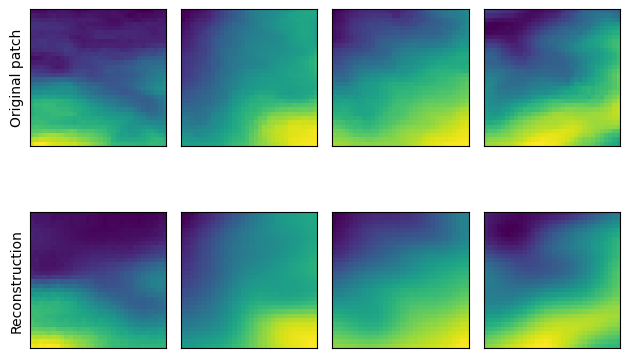

In [31]:
fig, axes = plt.subplots(2, n_examples)

for i_col in range(n_examples):
    axes[0, i_col].imshow(inputs[i_col, 0, ...])
    axes[1, i_col].imshow(outputs[i_col, 0, ...])

for a in axes.flat:
    a.set_xticks([])
    a.set_yticks([])

axes[0, 0].set_ylabel("Original patch")
axes[1, 0].set_ylabel("Reconstruction")

fig.tight_layout()
plt.show()

## Reconstruction 1: Getting the full array back

Suppose we would like to evaluate how the autoencoder does on reconstructing the entire terrain patch by combining outputs across all input patches. To do so we can use the `predict_on_array` function described in the previous notebook. Our model outputs tensors with shape `(band=1, x=32, y=32)`. We need to specify each of these axes in the call to `predict_on_array`. `band` does not change size and is not used by the `BatchGenerator`, so it goes in `core_dim`. Both `x` and `y` are used by the `BatchGenerator`, so although they do not change size they still go in `resample_dim`. That accounts for all tensor axes, so we can leave the `new_dim` argument as an empty list.

In [32]:
dem_reconst = functions.predict_on_array(
    dataset=ds,
    model=m,
    output_tensor_dim=dict(band=1, y=32, x=32),
    new_dim=[],
    core_dim=["band"],
    resample_dim=["x", "y"]
)

  0%|          | 0/3136 [00:00<?, ?it/s]

100%|██████████| 3136/3136 [00:51<00:00, 60.50it/s]


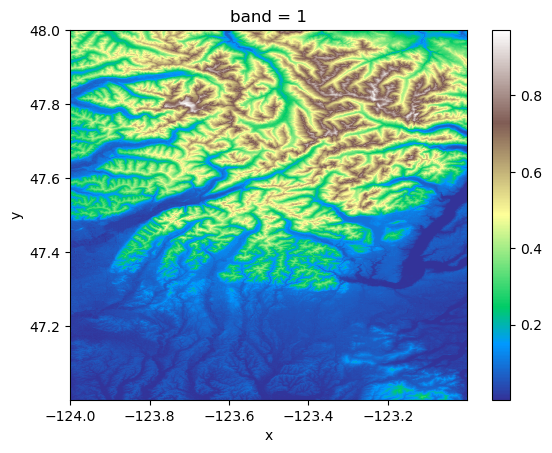

In [33]:
dem_reconst.isel(band=0).plot.imshow(cmap="terrain")

That certainly looks like the original DEM. Let's try plotting the error in the reconstruction.

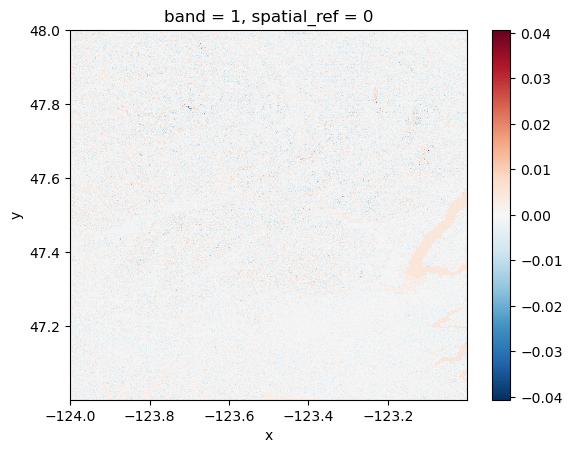

In [34]:
err = (dem_reconst - dem)
err.isel(band=0).plot.imshow()
plt.show()

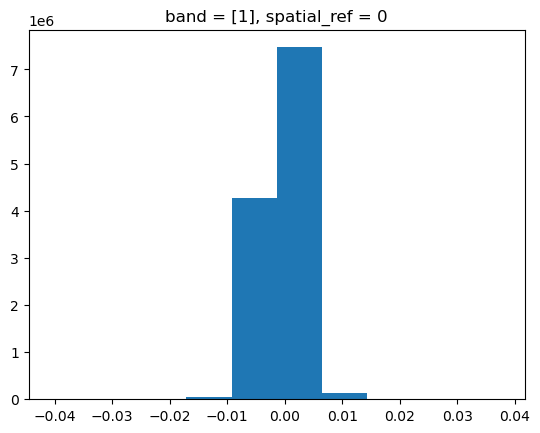

In [35]:
err.plot.hist()
plt.show()

Not bad!

## Reconstruction 2: Getting the latent dimension

A common application of autoencoders is to use the latent dimension for some application. Let's turn our autoencoder's predictions into a data cube. To do so we will modify the batch generator to not have overlapping windows. We also have to slightly clip the size of the input DEM. This is because we are effectively downscaling the spatial axes by a factor of 32. Since `3600 / 32` is not an integer, `predict_on_array` will not know how to rescale the array size. So, we have to clip the DEM to the nearest integer multiple of 32. In this case the nearest multiple is 3584, which we achieve by clipping 8 pixels from each side.

In [36]:
bgen_no_overlap = xbatcher.BatchGenerator(
    dem.isel(x=slice(8, -8), y=slice(8, -8)),
    input_dims=dict(x=32, y=32),
    input_overlap=dict(x=0, y=0)
)

ds_no_overlap = MapDataset(
    X_generator=bgen_no_overlap
)

loader = torch.utils.data.DataLoader(ds_no_overlap, batch_size=16, shuffle=True)

ex_input = next(iter(loader))

# Same as before
print("Input shape:", ex_input.shape)

Input shape: torch.Size([16, 1, 32, 32])


Next we will write a function that the calls the encoder arm of the autoencoder and adds a fake x and y dimension.

In [37]:
def infer_with_encoder(x):
    return m.encoder(x)[:, None, None, :]

ex_output = infer_with_encoder(ex_input)
print("Output shape:", ex_output.shape)

Output shape: torch.Size([16, 1, 1, 64])


To be clear, we started with the usual x/y/band tensor from the input dataset.

<svg width="177" height="167" style="stroke:rgb(0,0,0);stroke-width:1"> <!-- Horizontal lines -->
    <line x1="10" y1="0" x2="27" y2="17" style="stroke-width:2" />
    <line x1="10" y1="100" x2="27" y2="117" style="stroke-width:2" /> <!-- Vertical lines -->
    <line x1="10" y1="0" x2="10" y2="100" style="stroke-width:2" />
    <line x1="27" y1="17" x2="27" y2="117" style="stroke-width:2" /> <!-- Colored Rectangle -->
    <polygon points="10.0,0.0 27.578209484906253,17.578209484906253 27.578209484906253,117.57820948490625 10.0,100.0"
        style="fill:#ECB172A0;stroke-width:0" /> <!-- Horizontal lines -->
    <line x1="10" y1="0" x2="110" y2="0" style="stroke-width:2" />
    <line x1="27" y1="17" x2="127" y2="17" style="stroke-width:2" /> <!-- Vertical lines -->
    <line x1="10" y1="0" x2="27" y2="17" style="stroke-width:2" />
    <line x1="110" y1="0" x2="127" y2="17" style="stroke-width:2" /> <!-- Colored Rectangle -->
    <polygon points="10.0,0.0 110.0,0.0 127.57820948490625,17.578209484906253 27.578209484906253,17.578209484906253"
        style="fill:#ECB172A0;stroke-width:0" /> <!-- Horizontal lines -->
    <line x1="27" y1="17" x2="127" y2="17" style="stroke-width:2" />
    <line x1="27" y1="117" x2="127" y2="117" style="stroke-width:2" /> <!-- Vertical lines -->
    <line x1="27" y1="17" x2="27" y2="117" style="stroke-width:2" />
    <line x1="127" y1="17" x2="127" y2="117" style="stroke-width:2" /> <!-- Colored Rectangle -->
    <polygon
        points="27.578209484906253,17.578209484906253 127.57820948490625,17.578209484906253 127.57820948490625,117.57820948490625 27.578209484906253,117.57820948490625"
        style="fill:#ECB172A0;stroke-width:0" /> <!-- Text --> <text x="77.578209" y="137.578209" font-size="1.0rem"
        font-weight="100" text-anchor="middle">x: 32</text> <text x="147.578209" y="67.578209" font-size="1.0rem"
        font-weight="100" text-anchor="middle" transform="rotate(0,147.578209,67.578209)">y: 32</text> <text x="8.789105"
        y="128.789105" font-size="1.0rem" font-weight="100" text-anchor="middle"
        transform="rotate(45,8.789105,128.789105)">band: 1</text>
</svg>

...and end up with a tensor that has singleton x/y dimensions and a new, 64-element channel dimension.

<svg width="141" height="131" style="stroke:rgb(0,0,0);stroke-width:1"> <!-- Horizontal lines -->
    <line x1="10" y1="0" x2="68" y2="58" style="stroke-width:2" />
    <line x1="10" y1="23" x2="68" y2="81" style="stroke-width:2" /> <!-- Vertical lines -->
    <line x1="10" y1="0" x2="10" y2="23" style="stroke-width:2" />
    <line x1="68" y1="58" x2="68" y2="81" style="stroke-width:2" /> <!-- Colored Rectangle -->
    <polygon
        points="10.0,0.0 68.82352941176471,58.82352941176471 68.82352941176471,81.8863520766876 10.0,23.062822664922887"
        style="fill:#ECB172A0;stroke-width:0" /> <!-- Horizontal lines -->
    <line x1="10" y1="0" x2="33" y2="0" style="stroke-width:2" />
    <line x1="68" y1="58" x2="91" y2="58" style="stroke-width:2" /> <!-- Vertical lines -->
    <line x1="10" y1="0" x2="68" y2="58" style="stroke-width:2" />
    <line x1="33" y1="0" x2="91" y2="58" style="stroke-width:2" /> <!-- Colored Rectangle -->
    <polygon
        points="10.0,0.0 33.06282266492289,0.0 91.8863520766876,58.82352941176471 68.82352941176471,58.82352941176471"
        style="fill:#ECB172A0;stroke-width:0" /> <!-- Horizontal lines -->
    <line x1="68" y1="58" x2="91" y2="58" style="stroke-width:2" />
    <line x1="68" y1="81" x2="91" y2="81" style="stroke-width:2" /> <!-- Vertical lines -->
    <line x1="68" y1="58" x2="68" y2="81" style="stroke-width:2" />
    <line x1="91" y1="58" x2="91" y2="81" style="stroke-width:2" /> <!-- Colored Rectangle -->
    <polygon
        points="68.82352941176471,58.82352941176471 91.8863520766876,58.82352941176471 91.8863520766876,81.8863520766876 68.82352941176471,81.8863520766876"
        style="fill:#ECB172A0;stroke-width:0" /> <!-- Text --> <text x="80.354941" y="101.886352" font-size="1.0rem"
        font-weight="100" text-anchor="middle">y: 1</text> <text x="111.886352" y="70.354941" font-size="1.0rem"
        font-weight="100" text-anchor="middle" transform="rotate(0,111.886352,70.354941)">x: 1</text> <text x="29.411765"
        y="72.474587" font-size="1.0rem" font-weight="100" text-anchor="middle"
        transform="rotate(45,29.411765,72.474587)">channel: 64</text>
</svg>

We can go through the same process as before to see how we put together the `predict_on_array` call. Both the `x` and `y` dimensions change size and are used by the batch generator, so they go in `resample_dims`. The remaining dimension, `channel`, is a new dimension and goes in the `new_dim` list.

In [38]:
latent_dim_cube = functions.predict_on_array(
    dataset=ds_no_overlap,
    model=infer_with_encoder,
    output_tensor_dim=dict(y=1, x=1, channel=64),
    new_dim=["channel"],
    core_dim=[],
    resample_dim=["x", "y"]
)

100%|██████████| 784/784 [00:10<00:00, 75.65it/s]


In [39]:
latent_dim_cube

<xarray.DataArray (y: 112, x: 112, channel: 64)> Size: 6MB
array([[[-2.98959292e-01,  1.64430934e-01,  1.15438255e-02, ...,
         -8.08710732e-03,  3.30118317e-02, -5.46855937e-04],
        [-2.24567760e-03,  9.47532182e-02, -3.34303832e-02, ...,
         -6.48077535e-03,  8.64085204e-04, -1.95042637e-02],
        [-2.29584158e-02, -1.93482539e-01, -2.64102204e-02, ...,
         -5.21691757e-02, -2.33358999e-03, -1.43376856e-03],
        ...,
        [-7.14939087e-01,  3.34519677e-02, -1.22026729e-01, ...,
         -4.24666117e-02,  1.09958167e-01, -2.81837341e-02],
        [-1.44703043e+00, -6.82025516e-03, -1.32837495e-01, ...,
          1.01037129e-01,  1.24011525e-01,  2.93925781e-02],
        [-1.88280569e+00,  1.58894039e-01,  1.94406669e-01, ...,
          2.02963516e-01, -1.02580176e-01, -2.27122382e-02]],

       [[-3.11284028e-01,  4.57395907e-02, -5.93765944e-02, ...,
          9.89407912e-02,  6.95664992e-03, -2.08061733e-02],
        [-8.16732126e-02,  2.07674481e-01,  5.54563779e-02, ...,
         -3.88096709e-02,  3.14765790e-02, -7.57243798e-04],
        [-1.09194994e-01, -5.78870165e-03,  8.61930280e-02, ...,
          2.35724309e-02,  4.35084485e-02,  6.65596484e-04],
...
         -1.84319850e-01,  5.72853962e-02,  1.05324888e-01],
        [-2.57522762e+00,  4.06043765e-01,  2.18213096e-01, ...,
          2.16262191e-01,  2.44147664e-01, -2.79635558e-02],
        [-4.53882925e+00, -3.61320565e-01,  9.88348282e-02, ...,
         -9.99270161e-02, -1.89315409e-01,  7.27320120e-02]],

       [[-5.32383745e+00, -2.59905275e-01, -9.42536151e-02, ...,
         -1.14359197e-01, -7.32243057e-02, -1.17779599e-01],
        [-4.61458548e+00, -3.59844762e-01,  1.96055190e-01, ...,
         -9.51545225e-02, -2.07306574e-01, -1.21820868e-01],
        [-4.43024026e+00, -1.50307160e-01, -2.68508102e-01, ...,
          2.49489361e-02, -2.64294322e-01, -1.70129536e-02],
        ...,
        [-1.79788969e+00, -4.62374302e-01,  3.78449074e-02, ...,
         -1.45970427e-01, -1.10146726e-01, -3.16941288e-02],
        [-1.89689242e+00,  1.96203432e-01,  1.83354633e-02, ...,
         -1.92172321e-01,  7.78421414e-02, -5.74109845e-02],
        [-4.11928259e+00, -7.79838400e-01, -1.65173175e-01, ...,
          1.25174990e-01, -2.02087485e-01, -2.00104178e-02]]],
      shape=(112, 112, 64))
Coordinates:
  * y        (y) float64 896B 48.0 47.99 47.98 47.97 ... 47.04 47.03 47.02 47.01
  * x        (x) float64 896B -124.0 -124.0 -124.0 ... -123.0 -123.0 -123.0
Dimensions without coordinates: channel

Note that despite substantially re-arranging the input `DataArray`, we have retained the coordinate information at a resampled resolution.

If we simply sum the output over the channel dimension, we see that the encoder clearly distinguishes between upland and lowland areas.

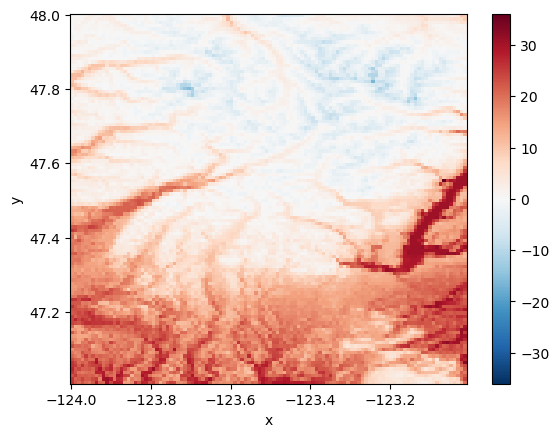

In [40]:
latent_dim_cube.sum(dim="channel").plot.imshow()

As a final demonstration of this workflow, let's compute the cosine similarity of each of the below pixels with the latent encoding of [Mt. Olympus](https://en.wikipedia.org/wiki/Mount_Olympus_(Washington)).

In [41]:
olympus = dict(x=-123.7066, y=47.7998)
olympus_latent = latent_dim_cube.sel(**olympus, method="nearest")
olympus_latent

<xarray.DataArray (channel: 64)> Size: 512B
array([ 3.05193448,  0.07984048, -0.19406716,  0.23198933, -0.28311083,
        0.06425693, -0.41277254,  0.10719062,  0.21293048,  0.18220075,
        0.02312008,  0.26989496, -3.81439401,  0.01594482,  0.21865739,
        2.11210263, -0.34720822, -0.01163836,  0.0337085 , -0.14257216,
       -2.99752761, -0.09423765,  0.09816827, -1.24537382, -2.30954931,
       -0.71140406,  0.2917199 , -0.0769781 , -0.03020979, -0.22612203,
       -2.74899594,  0.38115255, -0.82641506, -0.48060534,  0.07423552,
       -0.33775832,  0.22184855,  0.06239392,  1.01446021,  0.05642529,
        0.01650721,  1.78647155,  0.32631236, -0.45510718,  0.24257852,
        0.43398264, -0.04324041,  0.19464324,  0.64706841, -0.03532742,
       -0.28180135, -4.13436094,  3.57349098, -1.55306568, -4.02541322,
       -0.01129879, -0.14259338,  0.12843601, -0.26321372, -0.1023512 ,
       -3.86097112,  0.10304318,  0.17730129,  0.16089438])
Coordinates:
    y        float64 8B 47.8
    x        float64 8B -123.7
Dimensions without coordinates: channel

In [42]:
def numpy_cosine_similarity(x, y):
    return np.dot(x, y)/(norm(x)*norm(y))

In [43]:
olympus_similarity = xr.apply_ufunc(
    numpy_cosine_similarity,
    latent_dim_cube,
    input_core_dims = [["channel"]],
    output_core_dims = [[]],
    vectorize=True,
    kwargs=dict(y=olympus_latent.data)
)

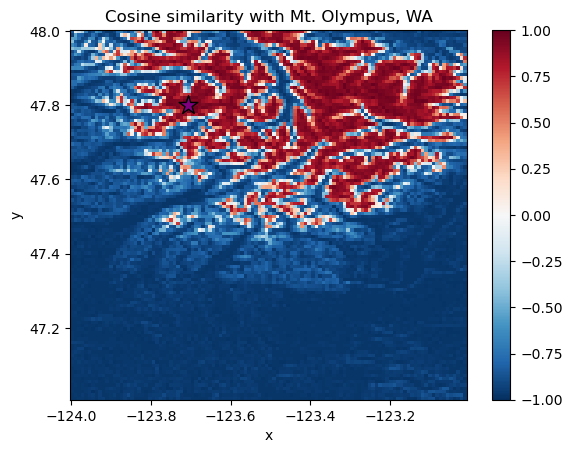

In [44]:
olympus_similarity.plot.imshow()
plt.scatter(olympus["x"], olympus["y"], marker="*", c="purple", edgecolor="black", s=200)
plt.title("Cosine similarity with Mt. Olympus, WA")
plt.show()

Similarly, we can identify foothills with similar topography to Grisdale, WA.

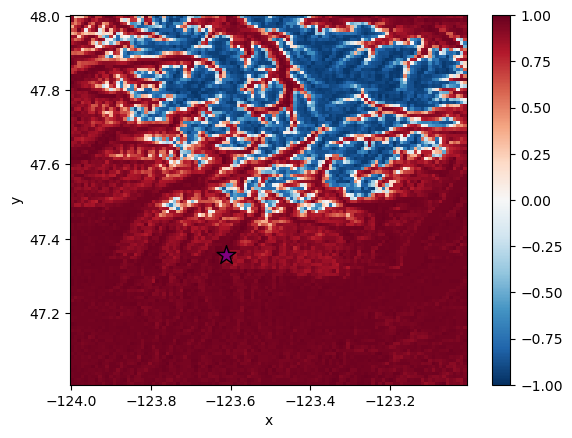

In [45]:
grisdale = dict(y=47.356625678465925, x=-123.61183314426664)
grisdale_latent = latent_dim_cube.sel(**grisdale, method="nearest")

grisdale_similarity = xr.apply_ufunc(
    numpy_cosine_similarity,
    latent_dim_cube,
    input_core_dims = [["channel"]],
    output_core_dims = [[]],
    vectorize=True,
    kwargs=dict(y=grisdale_latent.data)
)

grisdale_similarity.plot.imshow()
plt.scatter(grisdale["x"], grisdale["y"], marker="*", c="purple", edgecolor="black", s=200)
plt.show()

This result is admittedly very similar to if we had just selected elevation bands :)

---

## Summary
Our goal with this notebook has been to show how xbatcher supports linking `xarray` objects with deep learning models, and with converting model output back into labeled `xarray` objects. We have demonstrated two examples of reconstructing model output, both when tensor shape changes and when it does not.

If you encounter any issues, please open an issue on the GitHub repository for this cookbook. Other feedback is welcome!